In [1]:
from ipywidgets import IntProgress
from IPython.display import display
import time

from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

import pandas as pd
import geopandas as gpd

import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import timedelta
import datetime
from datetime import timedelta, date, datetime

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import imageio
from pygifsicle import optimize

plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

# Dimensiones de las variables

A partir de una clasificación de las variables en las dimensiones del artículo de Acharya aquí vamos a hacer algunas visualizaciones del índice.

Primero lo que hacemos es calcular la serie de tiempo de vulnerabilidad usando la tasa de mortalidad y las ariables reclasificadas

In [2]:
antier = date.today() - timedelta(days=2)
fecha_analisis = antier - timedelta(weeks=2)
fecha_analisis = pd.to_datetime(fecha_analisis)
metodo = 'PLS'
ventana_dias = 28
inicio = pd.to_datetime('20-05-01', yearfirst=True)
fin = antier - timedelta(days=7)
actualizar_datos_salud(fecha_inicio='18-02-2021')

In [3]:
serie_municipal = serie_covid_indicadores_municipales(antier.strftime('%y%m%d'),
                                                      acumulativa=False,
                                                      dias=ventana_dias,
                                                      indicadores='datos/municipios/indicadores_reclasificados.csv')
serie_municipal[['conteo', 'defunciones']] = serie_municipal[[f'conteo_{ventana_dias}dias',
                                                              f'defunciones_{ventana_dias}dias']]
serie_municipal = serie_municipal.drop(columns=[f'conteo_{ventana_dias}dias',
                                   f'defunciones_{ventana_dias}dias'])                                                              
serie_municipal = agregar_tasas_municipales(serie_municipal)

/home/datalab/app/covid19_vulnerabilidad_mex/datos.py:242: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['SEMANA_AÑO_INGRESO'] = df.index.week


In [4]:
modelos, serie = periodo_vulnerabilidad_con_dataframe(
            serie_municipal,
            inicio,
            fin,
            min_casos=10,
            columna='covid_defun_100k',
            rf=False
        )

<AxesSubplot:xlabel='FECHA_INGRESO', ylabel='valor_covid_defun_100k'>

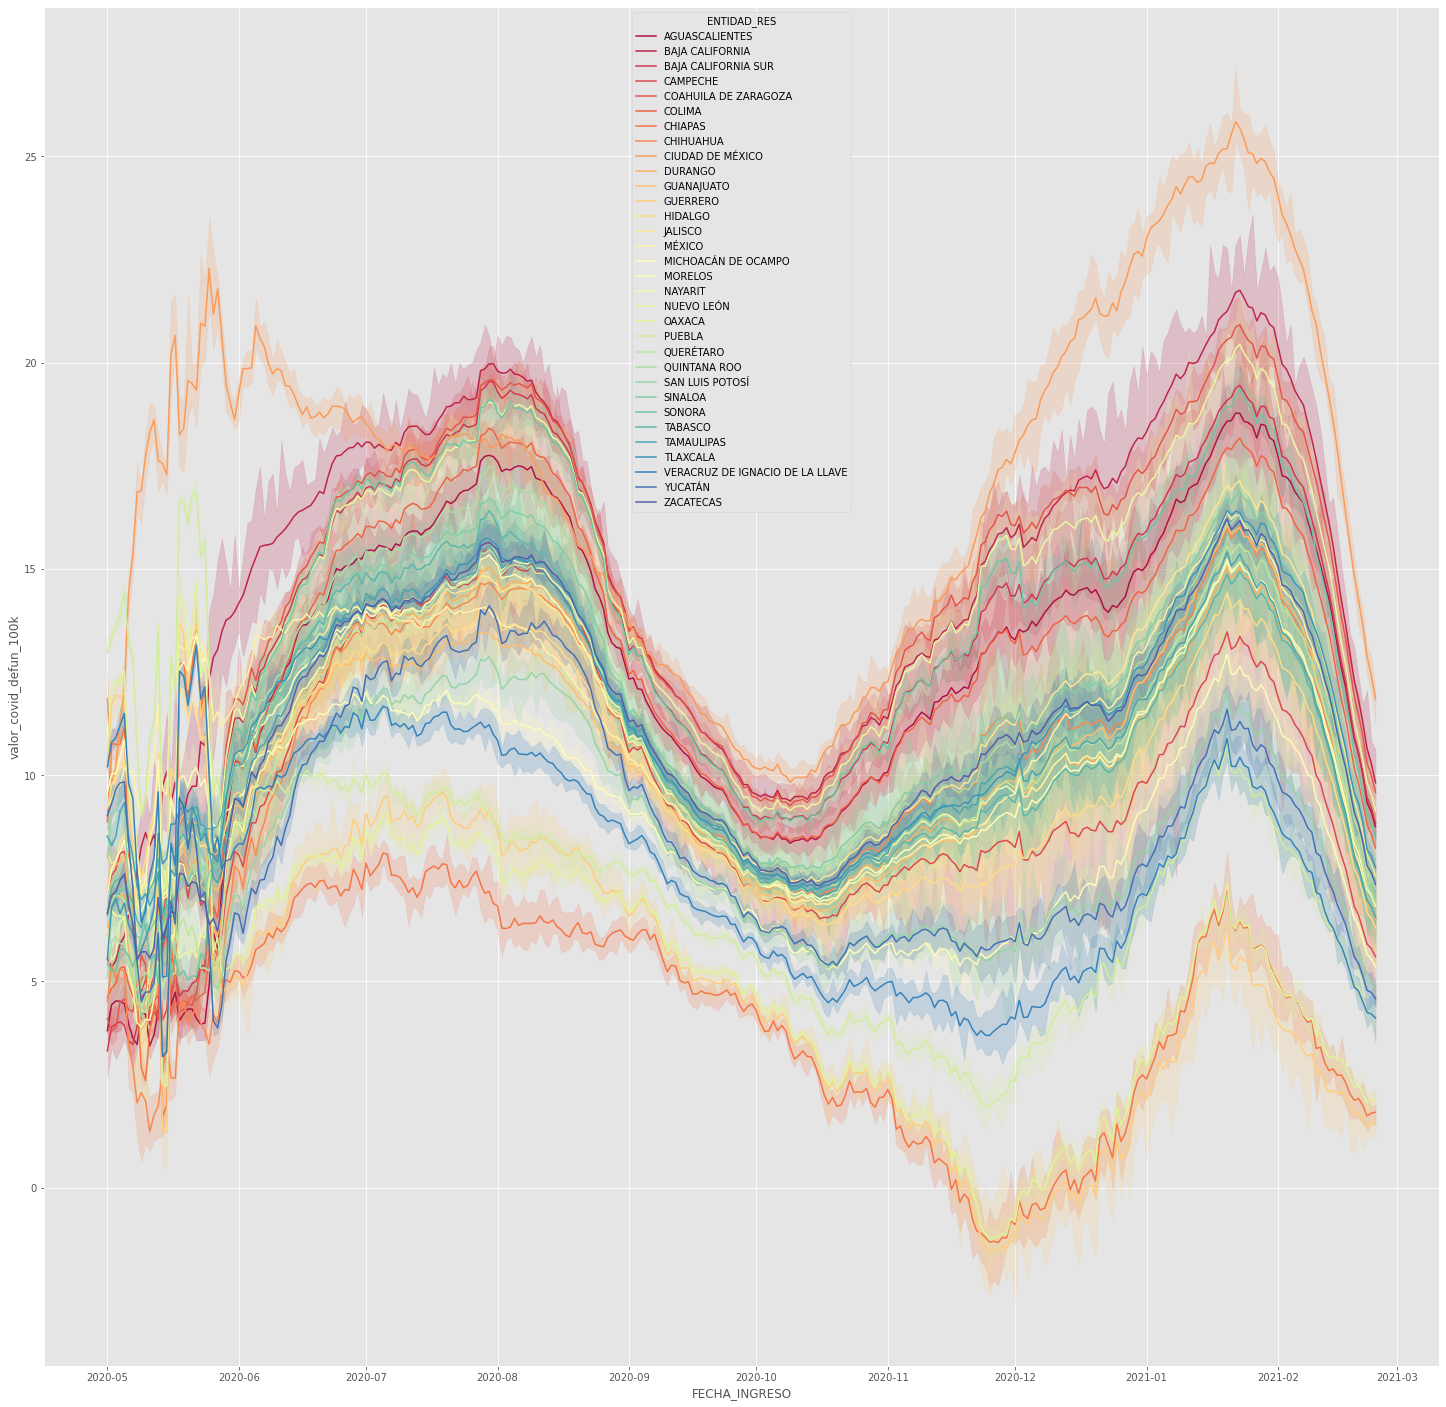

In [23]:
fig, ax = plt.subplots(figsize=(25, 25))
sns.lineplot(data=serie,
             x='FECHA_INGRESO', y=f'valor_covid_defun_100k',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)

## Importancia por dimensión

In [24]:
dimensiones = pd.read_csv("datos/diccionario_variables_usadas.csv")
modelos = modelos.merge(dimensiones, left_on='caracteristica', right_on='campo').drop(columns=['campo', 'descriptor'])
modelos

,caracteristica,coef,dia_ajuste,modelo,dimension
0,porc_carencia_salud,-0.334151,2020-05-01,PLS,Socioeconomic
1,porc_carencia_salud,-0.213215,2020-05-02,PLS,Socioeconomic
2,porc_carencia_salud,-0.259851,2020-05-03,PLS,Socioeconomic
3,porc_carencia_salud,-0.328650,2020-05-04,PLS,Socioeconomic
4,porc_carencia_salud,-0.339199,2020-05-05,PLS,Socioeconomic
...,...,...,...,...,...
11695,plb,-0.102000,2021-02-20,PLS,Socioeconomic
11696,plb,-0.094479,2021-02-21,PLS,Socioeconomic
11697,plb,-0.096841,2021-02-22,PLS,Socioeconomic
11698,plb,-0.089835,2021-02-23,PLS,Socioeconomic


In [25]:
modelos['mediana'] = (modelos
                      .groupby('caracteristica')['coef']
                      .transform('median'))
modelos.head()

,caracteristica,coef,dia_ajuste,modelo,dimension,mediana
0,porc_carencia_salud,-0.334151,2020-05-01,PLS,Socioeconomic,-0.06083
1,porc_carencia_salud,-0.213215,2020-05-02,PLS,Socioeconomic,-0.06083
2,porc_carencia_salud,-0.259851,2020-05-03,PLS,Socioeconomic,-0.06083
3,porc_carencia_salud,-0.328650,2020-05-04,PLS,Socioeconomic,-0.06083
4,porc_carencia_salud,-0.339199,2020-05-05,PLS,Socioeconomic,-0.06083


In [26]:
modelos.dimension.unique()

array(['Socioeconomic', 'Housing and hygiene', 'Health Care',
       'Epidemiological'], dtype=object)

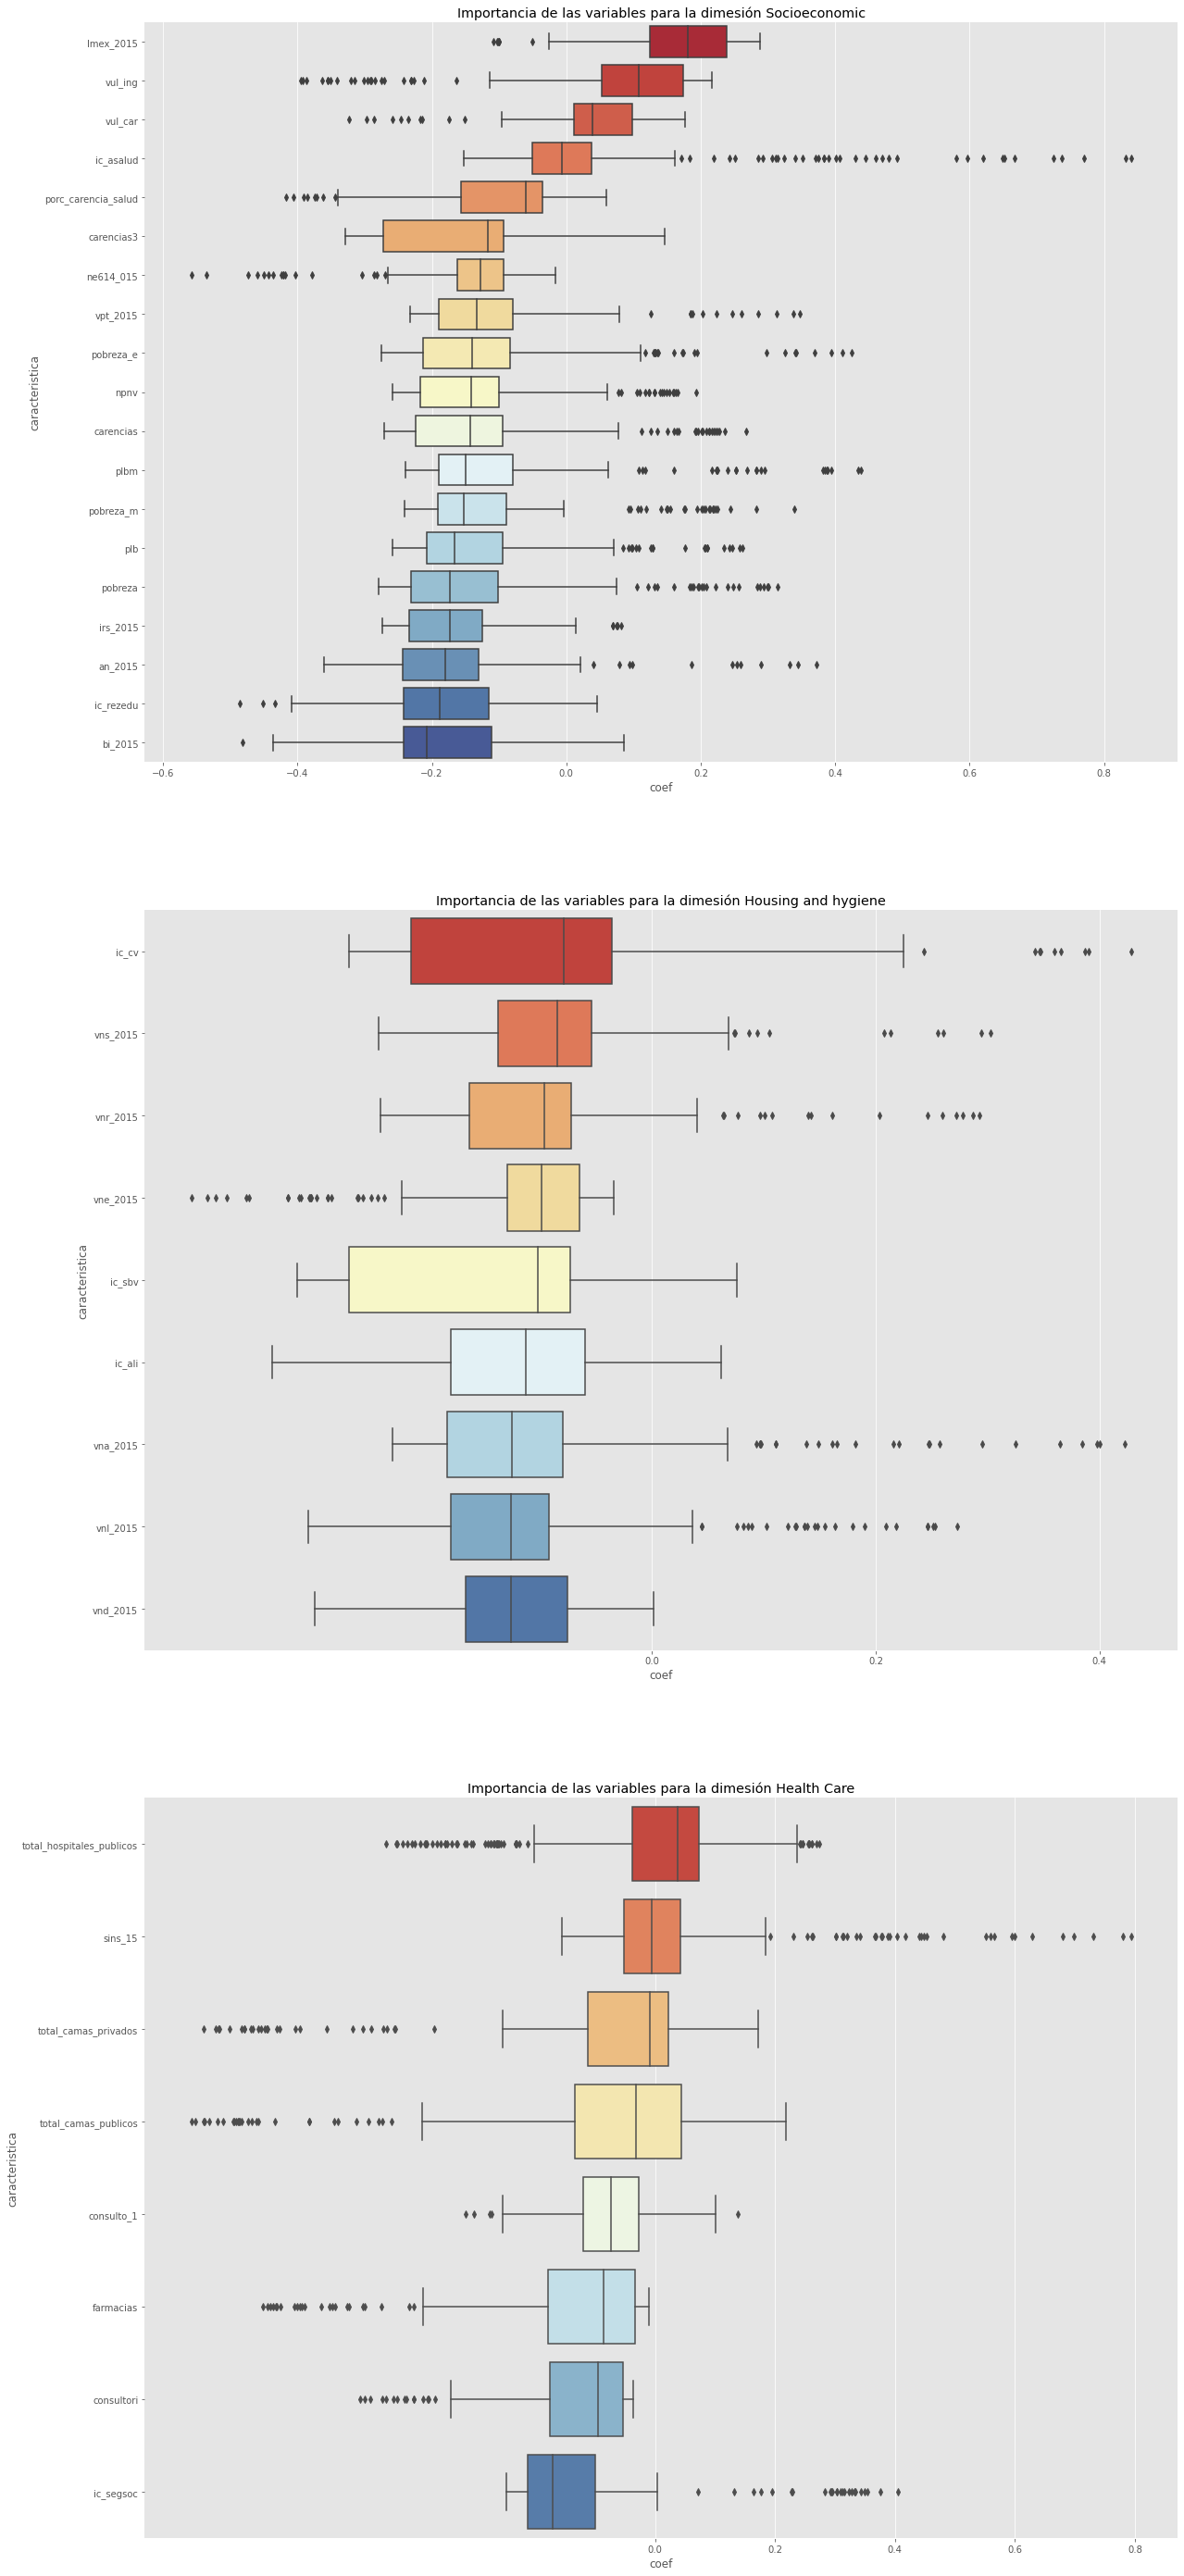

In [27]:
f, axes = plt.subplots(3,figsize=(20, 50))
lista_dimensiones = modelos.dimension.unique()
for i, ax in enumerate(axes):
    datos = modelos[modelos.dimension == lista_dimensiones[i]]
    datos = datos.sort_values(by='mediana', ascending=False)
    b = sns.boxplot(y="caracteristica", x="coef",
    data=datos,
    palette='RdYlBu',
    ax=ax)
    b.set_title(f'Importancia de las variables para la dimesión {lista_dimensiones[i]}')
    sns.despine(trim=True, left=True)
plt.savefig('img/importancia_caracteristicas_por_dimension.png', bbox_inches='tight')